# TOBACCO - EfficientNet-B0 - PSS Three Page

In [1]:
#Experiment Setup
DATA = 'tobacco800'
INPUT_DIM = 3
OUTPUT_DIM = 4
OUTPUT_METRIC = 2
NN = 'effnetB0'
PRE_PROCESS = ''
POS_PROCESS = ''
FINETUNNING = 'Layer11'
EXPERIMENT = f'{DATA}_input_{INPUT_DIM}_classes_{OUTPUT_DIM}_nn_{NN}'
if PRE_PROCESS != '':
    EXPERIMENT += f'_PRE_{PRE_PROCESS}'
if POS_PROCESS != '':
    EXPERIMENT += f'_POS_{POS_PROCESS}'
if FINETUNNING != '':
    EXPERIMENT += f'_FT_{FINETUNNING}'
print(EXPERIMENT)

tobacco800_input_3_classes_4_nn_effnetB0_FT_Layer11


### Data Processing

Como sempre, importaremos os módulos de que precisamos. Ainda não há novas importações.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim.lr_scheduler import _LRScheduler
from torch import optim
import torch.utils.data as data

import timm
from timm.optim import optim_factory
from types import SimpleNamespace

from efficientnet_pytorch import EfficientNet

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

import pandas as pd
from PIL import Image

from skimage import io as skio, transform
import cv2
import math

import re

from utils import *
from nn_modules import ThreePagesEffModule

Também definiremos as sementes aleatórias.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Definindo o Modelo

In [4]:
model = ThreePagesEffModule(OUTPUT_DIM, False, 14)
#Pesos pré-treinados carregados para eficientenet-b

Loaded pretrained weights for efficientnet-b0


### Data Processing

In [5]:
pretrained_size = (224,224)
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

class ResizeBinarize(object):
    def __call__(self, image):
        if len(image.shape)>2:
            image=image[0,:,:]
        resized = cv2.resize(image, (224,224), interpolation = cv2.INTER_CUBIC)
        retval,bin = cv2.threshold(resized,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return bin

transform = transforms.Compose([
                            ResizeBinarize(),
                            #transforms.Resize(pretrained_size),
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
                            #transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
                       ])

In [6]:
PAGE_IMGS_PATH = './database_tobacoo800/SinglePageTIF/'
TRAIN_LABEL_PATH = './database_tobacoo800/train.csv'
TEST_LABEL_PATH = './database_tobacoo800/test.csv'

In [7]:
print(PAGE_IMGS_PATH)

./database_tobacoo800/SinglePageTIF/


In [8]:
df_train = pd.read_csv(TRAIN_LABEL_PATH, sep=';', skiprows=0, low_memory=False)
df_test = pd.read_csv(TEST_LABEL_PATH,sep=';', skiprows=0, low_memory=False)

In [9]:
#len(df_train),len(df_val), len(df_test)
len(df_train), len(df_test)

(1031, 259)

In [10]:
def get_docid_radical_and_page(row):
    match = re.match(r"^([a-zA-Z0-9\-]*)(_(\d+))?$",row['docid'])
    if match:
        #print(match.groups()[0])
        row['radical'] = match.groups()[0]
        row['page'] = int(match.groups()[2]) if match.groups()[2] else 1
    else:
        print(error, row)
    return row

def get_extended_class(x):
    page = x['page'] 
    pages = x['pages']
    if pages == 1: 
        x['extended_class'] = 'single page'
        return x
    if page == 1:
        x['extended_class'] = 'first of many'
        return x
    if page == pages:
        x['extended_class'] = 'last page'
        return x
    x['extended_class'] = 'middle'
    return x

In [11]:
def add_extended_class_column(df):
    df = df.apply(get_docid_radical_and_page, axis=1)
    df_aux = df.groupby(['radical'], as_index=False)[['page']].max()
    df_aux.rename(columns={'page':'pages'}, inplace=True)
    df = df.merge(df_aux, how='left', on='radical')
    df = df.apply(get_extended_class, axis=1)
    return df.copy()

In [12]:
df_train = add_extended_class_column(df_train)
df_test = add_extended_class_column(df_test)

In [13]:
df_val = df_train.iloc[-200:,:]
df_train = df_train.iloc[:-200,:]

In [14]:
label2Idx = {'single page': 3,'first of many': 2,'middle': 1,'last page':0}

In [15]:
class ThreePagesTobaccoDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    
    def __init__(self, dataframe, root_dir, label2Idx, transform=None):
        self.dataframe = dataframe
        self.root_dir=root_dir
        self.transform = transform
        self.label2Idx = label2Idx

    def __len__(self):
        return len(self.dataframe)
    
    def get_page_file_name_label(self, index, transform, target):
        if index < 0 or index >= len(self.dataframe):
            page = np.full_like(target, 255)
            file_name = None
            label = None
        else:     
            row = self.dataframe.iloc[index]
            file_name = row["docid"]+'.tif'
            page = skio.imread(self.root_dir+file_name,plugin='pil')
            label = row['extended_class']
        if transform:
            page = transform(page)
        return page, file_name, label

    def __getitem__(self, index):
        if type(index) != int:
            i = index.item()
        else: i = index
            
        row = self.dataframe.iloc[index]
        file_name = row["docid"]+'.tif'
        target_page = skio.imread(self.root_dir+file_name,plugin='pil')
        label = row['extended_class']        
        
        if index < 1:
            next_row = self.dataframe.iloc[index+1]
            prev_page = np.full_like(target_page, 255)
            next_name = next_row["docid"]+'.tif'
            next_page = skio.imread(self.root_dir+next_name,plugin='pil')
        elif index >= len(self.dataframe) - 1:
            prev_row = self.dataframe.iloc[index-1]
            next_page = np.full_like(target_page, 255)
            prev_name = prev_row["docid"]+'.tif'
            prev_page = skio.imread(self.root_dir+prev_name,plugin='pil')
        else:
            prev_row = self.dataframe.iloc[index-1]
            next_row = self.dataframe.iloc[index+1]
            prev_name = prev_row["docid"]+'.tif'
            prev_page = skio.imread(self.root_dir+prev_name,plugin='pil')
            next_name = next_row["docid"]+'.tif'
            next_page = skio.imread(self.root_dir+next_name,plugin='pil')            
                    
        if self.transform:
            target_page = self.transform(target_page)
            prev_page = self.transform(prev_page)
            next_page = self.transform(next_page)
            
        return (
            [prev_page, target_page, next_page],
            self.label2Idx[label],
            file_name
        )

In [16]:
train_data = ThreePagesTobaccoDataset(df_train,PAGE_IMGS_PATH, label2Idx, transform )

valid_data = ThreePagesTobaccoDataset(df_val,PAGE_IMGS_PATH, label2Idx, transform )

test_data = ThreePagesTobaccoDataset(df_test,PAGE_IMGS_PATH, label2Idx, transform )

Vamos imprimir o número de exemplos em cada divisão para garantir que eles estejam corretos

In [17]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of test examples: {len(test_data)}')

Number of training examples: 831
Number of validation examples: 200
Number of test examples: 259


Também plotaremos algumas imagens para garantir que as transformações pareçam sensatas - certificando-se de renormalizar nossos dados para que possamos visualizá-los com as cores corretas.

In [18]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def concat_images(imga, imgb, imgc):
    """
    Combines three color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    hc,wc = imgc.shape[:2]
    max_height = np.max([ha, hb, hc])
    total_width = wa+wb+wc
    new_img = np.zeros(shape=(max_height, total_width, 3))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    new_img[:hc,wa+wb:wa+wb+wc]=imgc
    return new_img 

def plot_images(images, labels, classes, file_names, normalize = True):

    n_images = len(labels)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):
        
        prev_image = images[i][0]
        curr_image = images[i][1]
        next_page = images[i][2]

        ax = fig.add_subplot(rows, cols, i+1)
        
        if normalize:
            prev_image = normalize_image(prev_image)
            curr_image = normalize_image(curr_image)
            next_page = normalize_image(next_page)

        prev_image = prev_image.permute(1, 2, 0).cpu().numpy()    
        curr_image = curr_image.permute(1, 2, 0).cpu().numpy()
        next_page = next_page.permute(1, 2, 0).cpu().numpy()

        ax.imshow(concat_images(prev_image, curr_image, next_page))
        ax.set_title(f'{classes[labels[i]]}\n' \
                     f'{file_names[i]}')   
        ax.axis('off')

Como podemos ver, as imagens maiores significam que podemos sair com maiores quantidades de rotação e corte com as imagens ainda parecendo razoáveis.

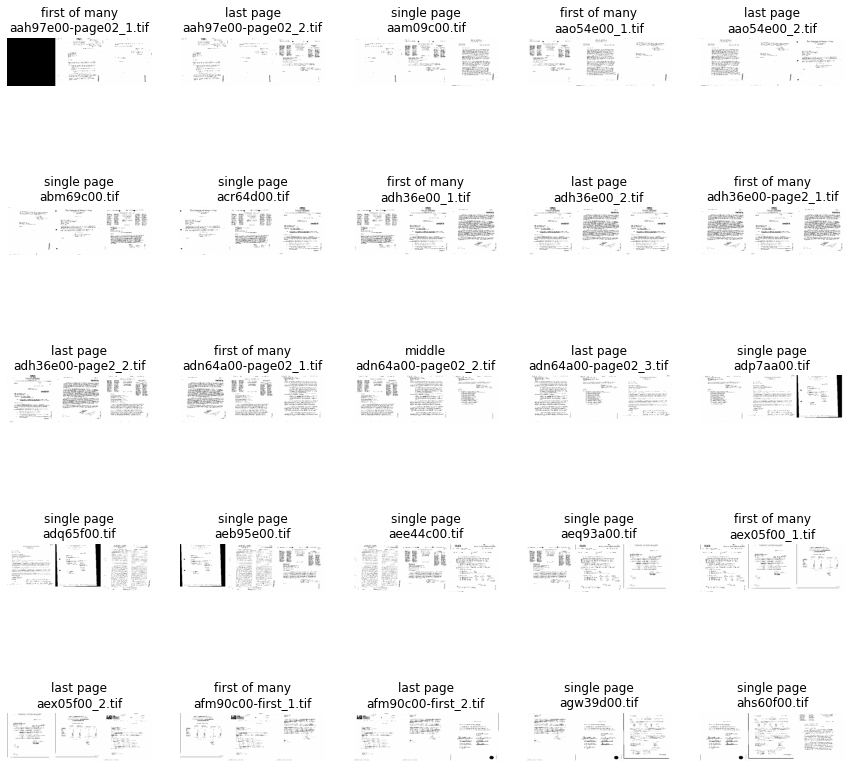

In [19]:
N_IMAGES = 25

images, labels, file_names = zip(*[(image, label, file_name) for image, label, file_name in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = {3: 'single page',2: 'first of many',1:'middle',0:'last page'}

#prev_images, curr_images = images[0]

plot_images(images, labels, classes, file_names)

In [20]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 batch_size = BATCH_SIZE, shuffle=False)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, 
                                 batch_size = BATCH_SIZE)

### Treinando o Modelo
Usaremos o localizador de taxa de aprendizado usado em notebooks anteriores. Geralmente ao usar um modelo pré-treinado a taxa de aprendizado utilizada será consideravelmente menor.

Primeiro, configuraremos o otimizador com a taxa de aprendizado inicial muito menor do que esperamos usar. Em seguida, definimos o dispositivo para colocar nosso modelo em nossa GPU, se tivermos uma. Em seguida, definimos o critério (função de perda) e colocamos o modelo e critério em nosso dispositivo.

In [21]:
FOUND_LR = 5e-3

params = [
          {'params': model.base_model.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


Criamos uma função para calcular a precisão...

In [22]:
def calculate_accuracy(y_pred, y): 
    correct = y_pred.eq(y.view_as(y_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...criar uma função que implemente um loop de treinamento...

In [23]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_acc_2 = 0
    epoch_kappa = 0
    epoch_kappa_2 = 0
    
    model.train()
    
    for (x, y, name) in iterator:
        
        x1, x2, x3 = x
        
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x1, x2, x3)
        
        loss = criterion(y_pred, y)
        
        top_pred = y_pred.argmax(1, keepdim = True)
        
        acc = calculate_accuracy(top_pred, y)
        #acc = calculate_accuracy(torch.div(top_pred, y, rounding_mode='trunc'))
        #acc_2 = calculate_accuracy(top_pred//2, y//2)
        acc_2 = calculate_accuracy(torch.div(top_pred, 2, rounding_mode='trunc'), torch.div(y, 2, rounding_mode='trunc'))

        kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())
        #kappa_2 = cohen_kappa_score((y//2).tolist(), top_pred.flatten().cpu()//2)
        kappa_2 = cohen_kappa_score(torch.div(y, 2, rounding_mode='trunc').tolist(), torch.div(top_pred.flatten().cpu(), 2, rounding_mode='trunc'))
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_acc_2 += acc_2.item()
        epoch_kappa += 1.0 if math.isnan(kappa) else kappa
        epoch_kappa_2 += 1.0 if math.isnan(kappa_2) else kappa_2
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator), epoch_acc_2 / len(iterator), epoch_kappa_2 

...criar uma função que executa um loop de avaliação...

In [24]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_acc_2 = 0
    epoch_kappa = 0
    epoch_kappa_2 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y, _) in iterator:
            
            x1, x2, x3 = x
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)            
            y = y.to(device)

            y_pred = model(x1, x2, x3)

            loss = criterion(y_pred, y)

            top_pred = y_pred.argmax(1, keepdim = True)

            acc = calculate_accuracy(top_pred, y)
            #acc_2 = calculate_accuracy(top_pred//2, y//2)
            acc_2 = calculate_accuracy(torch.div(top_pred, 2, rounding_mode='trunc'), torch.div(y, 2, rounding_mode='trunc'))

            kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())
            #kappa_2 = cohen_kappa_score((y//2).tolist(), top_pred.flatten().cpu()//2)
            kappa_2 = cohen_kappa_score(torch.div(y, 2, rounding_mode='trunc').tolist(), torch.div(top_pred.flatten().cpu(), 2, rounding_mode='trunc'))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_acc_2 += acc_2.item()
            epoch_kappa += 1.0 if math.isnan(kappa) else kappa
            epoch_kappa_2 += 1.0 if math.isnan(kappa_2) else kappa_2
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator), epoch_acc_2 / len(iterator), epoch_kappa_2 / len(iterator)

...e uma função auxiliar para nos dizer quanto tempo leva uma época.

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Por fim, treinamos nosso modelo.

Como nossas imagens foram redimensionadas para serem significativamente maiores e nosso modelo tem significativamente mais parâmetros, o treinamento leva muito mais tempo. No entanto, ao realizar o aprendizado de transferência, geralmente treinamos por períodos significativamente menores e ainda conseguimos obter uma precisão muito maior do que antes.

In [27]:
EPOCHS = 20

best_valid_loss = float('inf')

experiment_data = []

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc, train_kappa, train_acc_2, train_kappa_2 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, valid_kappa, valid_acc_2, valid_kappa_2 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print (f'Winner Epoch: {epoch+1:02}.')
        torch.save(model.state_dict(), './model/'+ EXPERIMENT+ '.pt')
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train Kappa: {train_kappa*100:.2f}% | Train Acc 2: {train_acc_2*100:.2f}% | Train Kappa 2: {train_kappa_2*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% |  Val. Kappa: {valid_kappa*100:.2f}% |  Val. Acc 2: {valid_acc_2*100:.2f}% |  Val. Kappa 2: {valid_kappa_2*100:.2f}%')

    experiment_data.append([train_loss, valid_loss, train_acc, valid_acc, train_kappa, valid_kappa, train_acc_2, valid_acc_2, train_kappa_2, valid_kappa_2, start_time, end_time])
    experiment_df = pd.DataFrame(experiment_data,columns=['train_loss','valid_loss','train_acc', 'valid_acc','train_kappa', 'valid_kappa', 'train_acc_2', 'valid_acc_2', 'train_kappa_2', 'valid_kappa_2', 'start', 'end' ])
    experiment_df.to_pickle('./model/'+ EXPERIMENT+ '.pk')

Winner Epoch: 01.
Epoch: 01 | Epoch Time: 14m 53s
	Train Loss: 1.360 | Train Acc: 40.81% | Train Kappa: 17.29% | Train Acc 2: 62.23% | Train Kappa 2: 473.96%
	 Val. Loss: 1.382 |  Val. Acc: 34.38% |  Val. Kappa: 1.48% |  Val. Acc 2: 53.12% |  Val. Kappa 2: 3.48%
Epoch: 02 | Epoch Time: 15m 34s
	Train Loss: 1.221 | Train Acc: 66.19% | Train Kappa: 50.68% | Train Acc 2: 78.71% | Train Kappa 2: 1397.08%
	 Val. Loss: 1.387 |  Val. Acc: 26.79% |  Val. Kappa: 4.73% |  Val. Acc 2: 51.79% |  Val. Kappa 2: 5.39%
Winner Epoch: 03.
Epoch: 03 | Epoch Time: 14m 18s
	Train Loss: 1.104 | Train Acc: 73.18% | Train Kappa: 61.96% | Train Acc 2: 82.80% | Train Kappa 2: 1647.88%
	 Val. Loss: 1.377 |  Val. Acc: 32.14% |  Val. Kappa: 12.32% |  Val. Acc 2: 58.04% |  Val. Kappa 2: 15.04%
Winner Epoch: 04.
Epoch: 04 | Epoch Time: 13m 59s
	Train Loss: 1.000 | Train Acc: 83.89% | Train Kappa: 77.60% | Train Acc 2: 90.38% | Train Kappa 2: 2091.79%
	 Val. Loss: 1.372 |  Val. Acc: 29.91% |  Val. Kappa: 11.46% |  Va

In [28]:
experiment_df = pd.read_pickle('./model/'+ EXPERIMENT+ '.pk')

In [29]:
print(EXPERIMENT)
print(experiment_df.sort_values(by=['valid_loss']).iloc[0])
train_loss, valid_loss, train_acc,valid_acc,test_kappa,valid_kappa,train_acc_2,valid_acc_2,train_kappa_2,valid_kappa_2,start,end = experiment_df.sort_values(by=['valid_loss']).iloc[0]

tobacco800_input_3_classes_4_nn_effnetB0_FT_Layer11
train_loss           0.762196
valid_loss           1.113774
train_acc            0.992788
valid_acc            0.616071
train_kappa          0.980570
valid_kappa          0.485491
train_acc_2          0.996394
valid_acc_2          0.785714
train_kappa_2       25.573864
valid_kappa_2        0.568177
start            75246.353755
end              76017.327523
Name: 18, dtype: float64


In [30]:
model.load_state_dict(torch.load('./model/'+ EXPERIMENT+ '.pt'))

test_loss, test_acc, test_kappa, test_acc_2, test_kappa_2 = evaluate(model, test_iterator, criterion, device)

print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}% |  Val. Kappa: {test_kappa*100:.2f}% |  Val. Acc 2: {test_acc_2*100:.2f}% |  Val. Kappa 2: {test_kappa_2*100:.2f}%')

	 Val. Loss: 1.026 |  Val. Acc: 73.96% |  Val. Kappa: 62.84% |  Val. Acc 2: 84.72% |  Val. Kappa 2: 67.84%


### Examinando o modelo

Faremos os mesmos exames no modelo que fizemos nos notebooks anteriores.

Primeiro, obteremos as previsões para cada um dos exemplos no conjunto de teste...

In [31]:
def get_predictions(model, iterator):

    model.eval()

    prev_page_images = []
    curr_page_images = []
    next_page_images = []
    
    labels = []
    probs = []
    file_names = []

    with torch.no_grad():

        for (x, y, name) in iterator:

            prev_page, curr_page, next_page = x
            prev_page = prev_page.to(device)
            curr_page = curr_page.to(device)
            next_page = next_page.to(device)
            
            y_pred = model(prev_page, curr_page, next_page)
            
            #concat_images(prev_page.cpu(), curr_page.cpu(), next_page.cpu())

            prev_page_images.append(prev_page.cpu())
            curr_page_images.append(curr_page.cpu())
            next_page_images.append(next_page.cpu())
            #labels.append(y.cpu()//2)
            labels.append(torch.div(y.cpu(), 2, rounding_mode='trunc'))
            probs.append(y_pred.cpu())
            file_names.append(name)

    prev_page_images = torch.cat(prev_page_images, dim = 0)
    curr_page_images = torch.cat(curr_page_images, dim = 0)
    next_page_images = torch.cat(next_page_images, dim = 0)    
    
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    file_names = list(sum(file_names, ()))

    return [prev_page_images, curr_page_images, next_page_images] , labels, probs, file_names

In [32]:
images, labels, probs, file_names = get_predictions(model, test_iterator)

...então obtenha os rótulos previstos para cada imagem...

In [33]:
#pred_labels = torch.argmax(probs, 1)//2
pred_labels = torch.div(torch.argmax(probs, 1), 2, rounding_mode='trunc')

...e então use essas previsões para criar uma matriz de confusão.

In [34]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    plt.savefig('./model/'+ EXPERIMENT+ '_confusion_matrix.png')

Semelhante ao caderno anterior, as classes mais comumente confundidas são cães e gatos.

In [35]:
classes = {'NextPage':0, 'FirstPage':1}

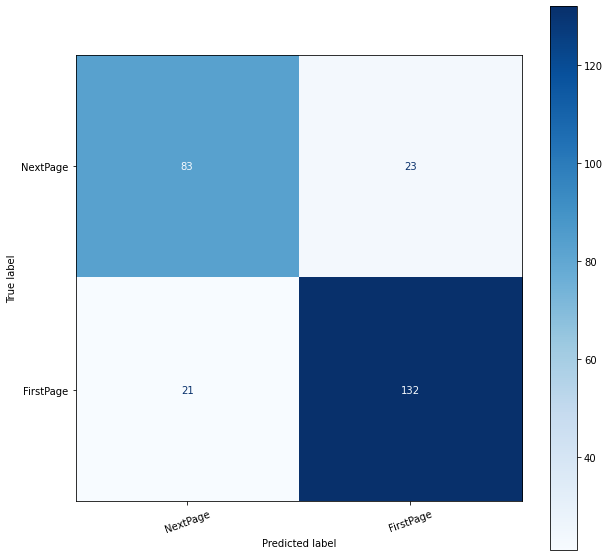

In [36]:
plot_confusion_matrix(labels, pred_labels, classes)

Em seguida, descobriremos quais previsões estavam incorretas e classificaremos essas previsões incorretas de acordo com a confiança do nosso modelo.

In [37]:
report_file_path = './report_final.json'
export_report(EXPERIMENT, 
              labels, 
              pred_labels, 
              list(classes.keys()),
              valid_loss, 
              valid_acc_2, 
              valid_kappa_2,               
              test_loss, 
              test_acc_2, 
              test_kappa_2, 
              report_file_path) 

{'tobacco800_input_3_classes_4_nn_effnetB0_FT_Layer11': {'NextPage': {'precision': 0.7980769230769231, 'recall': 0.7830188679245284, 'f1-score': 0.7904761904761906, 'support': 106}, 'FirstPage': {'precision': 0.8516129032258064, 'recall': 0.8627450980392157, 'f1-score': 0.8571428571428572, 'support': 153}, 'accuracy': 0.8301158301158301, 'macro avg': {'precision': 0.8248449131513648, 'recall': 0.8228819829818721, 'f1-score': 0.8238095238095239, 'support': 259}, 'weighted avg': {'precision': 0.8297024248637151, 'recall': 0.8301158301158301, 'f1-score': 0.8298584298584298, 'support': 259}, 'valid_acc': 0.7857142857142857, 'valid_kappa': 0.5681767483893224, 'test_acc': 0.8472222222222222, 'test_kappa': 0.6783768733969661}}
